<a href="https://colab.research.google.com/github/DanielMaschmann/PHANGS_HST_star_cluster/blob/main/accessing_phangs_hst_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jupyter notebook to access and visualize star clusters and compact associations in nearby galaxies.

The data release is presented here:
https://archive.stsci.edu/hlsp/phangs/phangs-cat
and the accompanying paper is [Maschmann et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240304901M/abstract).

We designed this Jupyter notebook in a way that the code should also work in normal python scripts.

For feedback and questions contact daniel.maschmann(at)rwth-aachen.de


In [ ]:
# packages needed to for file management,
# downloading and unpacking compressed catalogs.
import os
from urllib3 import PoolManager
import tarfile

# basic packages for data handling and plotting
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

from scipy.constants import c as speed_of_light

# we download a file with multiple helpfull methods from the same git repository.
# These functions are well documented to facilitate further reading.
helper_func_url = 'https://raw.githubusercontent.com/DanielMaschmann/PHANGS_HST_star_cluster/main/helper_func.py'
# Download file. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', helper_func_url, preload_content=False)
with open('helper_func.py', 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)

!pip install dust_extinction

# in case of updates
%load_ext autoreload
%autoreload 2
import importlib
import helper_func as helper_func
mylibrary = importlib.reload(helper_func)

In this Jupyter Notebook we will demonstrate to access and handle the cluster catalog for the Galaxy NGC 1566

In [4]:
# we use NGC ngc1097 as an example
galaxy_name = 'ngc1097'


Download the cluster and compact associataion catalogs and extract them.
The catalog data release is described here https://archive.stsci.edu/hlsp/phangs/phangs-cat and the list of the data products can be found here: https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table \

In [5]:
# get the file name and the URL for the catalogs
url_path_structure = 'https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/'
catalog_file_name_compressed = ('hlsp_phangs-cat_hst_acs-uvis_%s_multi_v1_cats.tar.gz' %
                    galaxy_name)
url = url_path_structure + catalog_file_name_compressed
# Download compressed catalogs. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', url, preload_content=False)
with open(catalog_file_name_compressed, 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
# get the present work directory (pwd) where we will extract the file
pwd = os.getcwd()
src_path = pwd + '/' + catalog_file_name_compressed
# extract the compressed files locally
tar = tarfile.open(src_path, 'r:gz')
tar.extractall(pwd)
tar.close()

In [6]:
# some galaxies have HST image mosaics. Therefore the file names can change!
mosaic_flag = True
if mosaic_flag:
  bundle_file_name = galaxy_name + 'mosaic'
else:
  bundle_file_name = galaxy_name

In [7]:
img_file_name_compressed = 'hlsp_phangs-hst_hst_wfc3-uvis_%s_multi_v1_drc-bundle.tar.gz' % bundle_file_name
url = 'https://archive.stsci.edu/hlsps/phangs-hst/' + bundle_file_name + '/' + img_file_name_compressed
# Download compressed image bundle. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', url, preload_content=False)
with open(img_file_name_compressed, 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
# get the present work directory (pwd) where we will extract the file
pwd = os.getcwd()
src_path = pwd + '/' + img_file_name_compressed
# extract the compressed files locally
tar = tarfile.open(src_path, 'r:gz')
tar.extractall(pwd)
tar.close()

Now we will access the cluster catalog for human class 1 and 2 and the catalog for compact associations (class 3)


In [8]:
fits_table = Table.read('../raw/candidate_table_%s.fits' % galaxy_name)

In [9]:
filtered_table = fits_table[~fits_table['PHANGS_CLUSTER_CLASS_HUMAN'].mask]  # Replace 'column_name' with your actual column


filtered_table['PHANGS_CLUSTER_CLASS_HUMAN'] = [
    min(value, 4) for value in filtered_table['PHANGS_CLUSTER_CLASS_HUMAN']
]

filtered_table.write("../raw/filtered_file.fits", overwrite=True)
filtered_table

INDEX,ID_PHANGS_CLUSTER,ID_PHANGS_CANDIDATE,ID_PHANGS_ALLSOURCES,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_GALAXY,PHANGS_DM_1,PHANGS_DMPC_1,PHANGS_DERR_1,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_CLUSTER_CLASS_ML_VGG_CORR
,,,,,,deg,deg,,,,,,,,
int64,int64,int64,int64,float64,float64,float64,float64,bytes7,float64,float64,float64,float64,int64,float64,int64
5,-999,5,1813,4975.44,1940.57,41.59600896122001,-30.322652612237484,ngc1097,30.664498849722413,13.58,2.04,4.0,9,0.7,9
26,-999,26,654,5441.44,2110.12,41.59006743234052,-30.32078707718581,ngc1097,30.664498849722413,13.58,2.04,4.0,9,0.9,9
38,19,38,5602,4801.12,2219.94,41.59823102243026,-30.3195777525278,ngc1097,30.664498849722413,13.58,2.04,1.0,1,1.0,1
52,25,52,3285,5384.11,2276.07,41.59079821677067,-30.31896066464826,ngc1097,30.664498849722413,13.58,2.04,3.0,2,0.7,2
59,28,59,1211,5385.52,2284.88,41.59078023253215,-30.318863706825663,ngc1097,30.664498849722413,13.58,2.04,2.0,2,1.0,2
79,39,79,4435,5328.34,2323.84,41.591509198913045,-30.31843488517973,ngc1097,30.664498849722413,13.58,2.04,2.0,2,1.0,2
99,-999,99,6097,4987.59,2381.69,41.59585341300243,-30.317797859628545,ngc1097,30.664498849722413,13.58,2.04,4.0,5,0.9,5
114,-999,114,8021,5149.72,2422.29,41.5937863455209,-30.317351220857812,ngc1097,30.664498849722413,13.58,2.04,4.0,5,1.0,5


In [10]:
# get all data we need for the following examples
# coordinates
ra_hum_cl1234, dec_hum_cl1234 = filtered_table['PHANGS_RA'], filtered_table['PHANGS_DEC']

# morphological classification
class_human_hum_cl1234 = filtered_table['PHANGS_CLUSTER_CLASS_HUMAN']


In order to visualize the location of the clusters we have to access the image data. As an example we use here the V-band (F555W).

In [11]:
# load the downloaded images
v_band_img_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_exp-drc-sci.fits' % (bundle_file_name, bundle_file_name))
v_band_img_header = v_band_img_hdu[0].header
v_band_img_data = v_band_img_hdu[0].data
v_band_img_wcs = WCS(v_band_img_header)

# change the image data from electron counts to units of Jy
# wavelength in angstrom
pivot_wavelength = v_band_img_header['PHOTPLAM']
# inverse sensitivity, ergs/cm2/Ang/electron
sensitivity = v_band_img_header['PHOTFLAM']
# speed of light in Angstrom/s
c = speed_of_light * 1e10
# change the conversion facto to get erg s−1 cm−2 Hz−1
f_nu = sensitivity * pivot_wavelength ** 2 / c
# change to get Jy
conversion_factor = f_nu * 1e23
# apply the conversion factor to the data
v_band_img_data *= conversion_factor

# this is not used in this tutorial but for completeness here we will load the uncertainty maps
v_band_invers_var_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_err-drc-wht.fits' % (bundle_file_name, bundle_file_name))
v_band_invers_var_data = v_band_invers_var_hdu[0].data
# the uncertainties are stored as inverse variance so we need to convert them into the standard deviation.
v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)
# and again we need to apply the conversion factor to these data
v_band_err_data *= conversion_factor





C:\Users\SEANM\AppData\Local\Temp\ipykernel_25240\2281417409.py:25: RuntimeWarning: divide by zero encountered in divide
  v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)


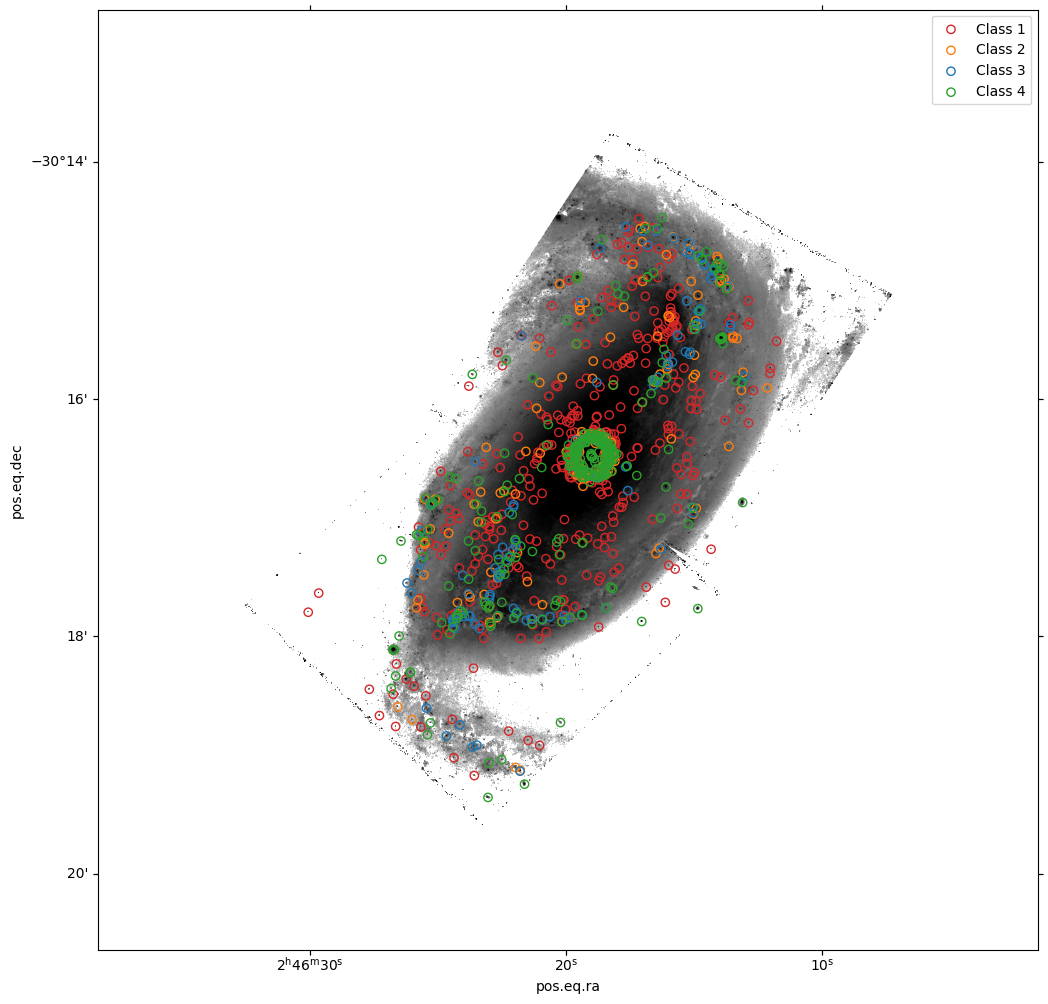

In [12]:
# in order to visualize the image we calculate some states of the image and calculate a strech.
mean, median, std = sigma_clipped_stats(v_band_img_data, sigma=3.0)
norm = LogNorm(0.1*std, median + 100*std)
figure = plt.figure(figsize=(10, 10))
ax_img = figure.add_axes([0.05, 0.05 , 0.94, 0.94], projection=v_band_img_wcs)
ax_img.imshow(v_band_img_data, cmap='Greys', norm=norm)

coords_hum_cl1234 = SkyCoord(ra=ra_hum_cl1234, dec=dec_hum_cl1234)
coords_hum_cl1234_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl1234)

ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==1],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==1],
               facecolor='None', edgecolor='tab:red', linewidth=1,
               label='Class 1')
ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==2],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==2],
               facecolor='None', edgecolor='tab:orange', linewidth=1,
               label='Class 2')
ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==3],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==3],
               facecolor='None', edgecolor='tab:blue', linewidth=1,
               label='Class 3')
ax_img.scatter(coords_hum_cl1234_pix[0][class_human_hum_cl1234==4],
               coords_hum_cl1234_pix[1][class_human_hum_cl1234==4],
               facecolor='None', edgecolor='tab:green', linewidth=1,
               label='Class 4')

ax_img.legend()

In [13]:
# cutout of random class 1, 2, 3 clusters
mask_class1 = class_human_hum_cl1234 == 1
mask_class2 = class_human_hum_cl1234 == 2
mask_class3 = class_human_hum_cl1234 == 3
mask_class4 = class_human_hum_cl1234 == 4

coord_bright_class1 = coords_hum_cl1234[mask_class1][101]
coord_bright_class2 = coords_hum_cl1234[mask_class2][13]
coord_bright_class3 = coords_hum_cl1234[mask_class3][1]
coord_bright_class4 = coords_hum_cl1234[mask_class4][0]

cutout_bright_class1 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class1,
                                                  cutout_size=(2, 2))
cutout_bright_class2 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class2,
                                                  cutout_size=(2, 2))
cutout_bright_class3 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class3,
                                                  cutout_size=(2, 2))
cutout_bright_class4 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class4,
                                                  cutout_size=(2, 2))

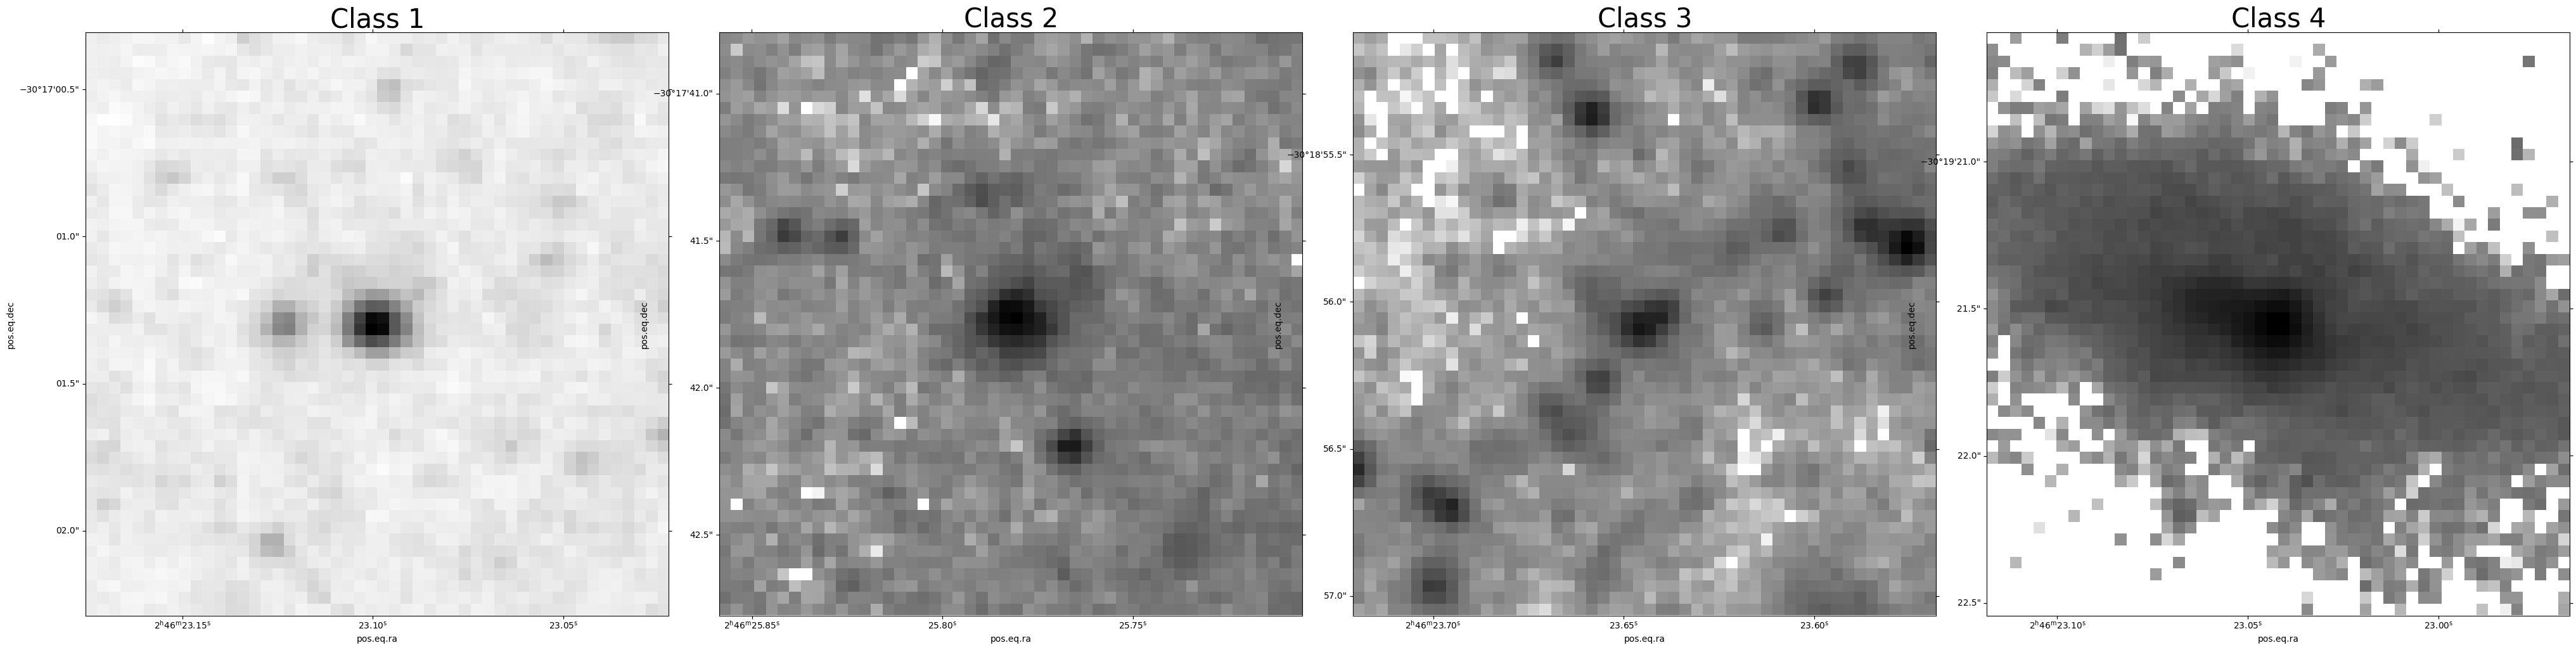

In [14]:
figure_cutouts = plt.figure(figsize=(40, 10))

ax_cutout_class1 = figure_cutouts.add_axes([0.01, 0.05, 0.23, 0.94], projection=cutout_bright_class1.wcs)
ax_cutout_class2 = figure_cutouts.add_axes([0.26, 0.05, 0.23, 0.94], projection=cutout_bright_class2.wcs)
ax_cutout_class3 = figure_cutouts.add_axes([0.51, 0.05, 0.23, 0.94], projection=cutout_bright_class3.wcs)
ax_cutout_class4 = figure_cutouts.add_axes([0.76, 0.05, 0.23, 0.94], projection=cutout_bright_class4.wcs)

ax_cutout_class1.imshow(cutout_bright_class1.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class2.imshow(cutout_bright_class2.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class3.imshow(cutout_bright_class3.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class4.imshow(cutout_bright_class4.data, norm=LogNorm(), cmap='Greys')

ax_cutout_class1.set_title('Class 1', fontsize=30)
ax_cutout_class2.set_title('Class 2', fontsize=30)
ax_cutout_class3.set_title('Class 3', fontsize=30)
ax_cutout_class4.set_title('Class 4', fontsize=30)

plt.show()


In [15]:
# Get all coordinates for each class
coords_class1 = coords_hum_cl1234[mask_class1]
coords_class2 = coords_hum_cl1234[mask_class2]
coords_class3 = coords_hum_cl1234[mask_class3]
coords_class4 = coords_hum_cl1234[mask_class4]

# Count the number of available cutouts (i.e., the number of coordinates) for each class
class_counts = {
    "class1": len(coords_class1),
    "class2": len(coords_class2),
    "class3": len(coords_class3),
    "class4": len(coords_class4),
}

# Print the number of available cutouts per class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} available cutouts")

class1: 417 available cutouts
class2: 198 available cutouts
class3: 159 available cutouts
class4: 408 available cutouts


In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random

def get_cutouts(size):

    # Determine available sizes
    available_class1 = len(coords_class1)
    available_class2 = len(coords_class2)
    available_class3 = len(coords_class3)
    available_class4 = len(coords_class4)
    
    total_available = available_class1 + available_class2 + available_class3 + available_class4
    size = min(size, total_available)  # Ensure we don't exceed available images
    
    # Randomly distribute the requested size across classes
    class_sizes = random.choices(["class1", "class2", "class3", "class4"], k=size)
    count_class1 = class_sizes.count("class1")
    count_class2 = class_sizes.count("class2")
    count_class3 = class_sizes.count("class3")
    count_class4 = class_sizes.count("class4")
    
    # Extract random cutouts
    cutouts_class1 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class1[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class1), min(count_class1, available_class1))
    ]
    
    cutouts_class2 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class2[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class2), min(count_class2, available_class2))
    ]
    
    cutouts_class3 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class3[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class3), min(count_class3, available_class3))
    ]

    cutouts_class4 = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_class4[i], cutout_size=(2, 2))
        for i in random.sample(range(available_class4), min(count_class4, available_class4))
    ]
    
    # Organize images and labels into a list
    dataset = []
    dataset.extend([(cutout.data, "class1") for cutout in cutouts_class1])
    dataset.extend([(cutout.data, "class2") for cutout in cutouts_class2])
    dataset.extend([(cutout.data, "class3") for cutout in cutouts_class3])
    dataset.extend([(cutout.data, "class4") for cutout in cutouts_class4])
    
    dataset

    return dataset

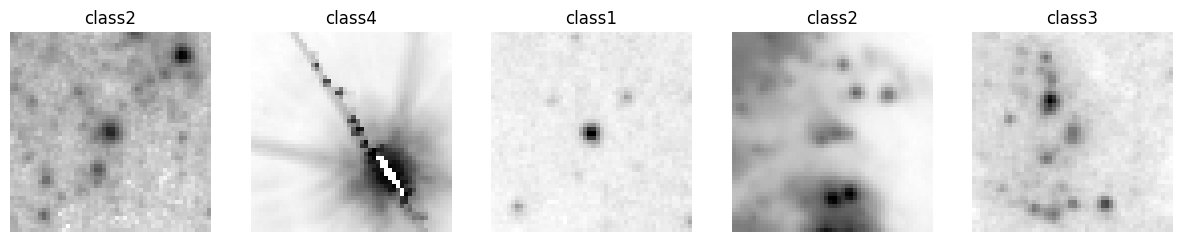

In [22]:
def test_get_cutouts():
    sample_size = 10  
    dataset = get_cutouts(sample_size)
    
    selected_images = random.sample(dataset, min(5, len(dataset)))

    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    for ax, (image, label) in zip(axes, selected_images):
        ax.imshow(image, cmap="Greys", norm=LogNorm())
        ax.set_title(label)
        ax.axis("off")
    plt.show()

# Run test
test_get_cutouts()
